# PRACTICE WITH PYTORCH #02
Nguyễn Anh Thư - 23127266

## 1. Import and Setup


In [28]:
# Uncomment the following lines to install required libraries
# Run this cell if you haven't installed the necessary packages yet
# 
# !pip install torch
# !pip install pandas
# !pip install matplotlib


In [29]:
import torch
torch.manual_seed(42)

## 2. Activation Functions


In [30]:
class Activation:
    """
    Collection of activation functions for a simple feed-forward neural network.
    Each method receives a tensor and returns a tensor with the same shape.
    """

    @staticmethod
    def sigmoid(s: torch.Tensor) -> torch.Tensor:
        """
        Sigmoid activation: 1 / (1 + exp(-s)).

        Args:
            s: Input tensor.

        Returns:
            Activated tensor.
        """
        return 1.0 / (1.0 + torch.exp(-s))

    @staticmethod
    def tanh(s: torch.Tensor) -> torch.Tensor:
        """
        Hyperbolic tangent activation.

        Args:
            s: Input tensor.

        Returns:
            Activated tensor.
        """
        return torch.tanh(s)


## 3. Activation Derivatives


In [31]:
class ActivationPrime:
    """
    Collection of activation derivatives for backpropagation.

    Important:
        In this project style, ActivationLayer.backward() passes the *pre-activation*
        tensor z (layer input before applying activation) into derivative functions.
    """

    @staticmethod
    def sigmoid_derivative(s: torch.Tensor) -> torch.Tensor:
        """
        Derivative of sigmoid with respect to its input (pre-activation z).

        sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))

        Args:
            s: Pre-activation tensor (z).

        Returns:
            Derivative tensor with same shape as s.
        """
        sig = Activation.sigmoid(s)
        return sig * (1.0 - sig)

    @staticmethod
    def tanh_derivative(s: torch.Tensor) -> torch.Tensor:
        """
        Derivative of tanh with respect to its input (pre-activation z).

        tanh'(z) = 1 - tanh(z)^2

        Args:
            s: Pre-activation tensor (z).

        Returns:
            Derivative tensor with same shape as s.
        """
        t = torch.tanh(s)
        return 1.0 - t ** 2


## 4. Loss Functions


In [32]:
class Loss:
    """Collection of loss functions."""

    @staticmethod
    def mse(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Mean Squared Error (MSE).

        Args:
            y_true: Ground-truth tensor.
            y_pred: Prediction tensor.

        Returns:
            Scalar tensor loss value.
        """
        return torch.mean((y_true - y_pred) ** 2)


class LossPrime:
    """Collection of loss derivatives."""

    @staticmethod
    def mse_prime(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Derivative of MSE w.r.t. y_pred.

        If L = mean((y_true - y_pred)^2),
        then dL/dy_pred = 2*(y_pred - y_true) / numel(y_true).

        Args:
            y_true: Ground-truth tensor.
            y_pred: Prediction tensor.

        Returns:
            Tensor gradient with same shape as y_pred.
        """
        return 2.0 * (y_pred - y_true) / y_true.numel()


## 5. Layers Implementation


In [33]:
class BaseLayer:
    """
    Base class for all neural network layers.
    
    Provides the interface that all layers must implement:
        - forward(in_data) -> out_data: Forward propagation
        - backward(out_error, rate) -> in_error: Backward propagation with gradient update
    """

    def __index__(self) -> None:
        """
        Placeholder method to resemble the sample structure.
        
        Returns:
            None
        """
        return None

    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the layer.
        
        Args:
            in_data: Input tensor to the layer.
        
        Returns:
            Output tensor after layer transformation.
        
        Raises:
            NotImplementedError: Must be implemented by subclasses.
        """
        raise NotImplementedError("forward() must be implemented by subclasses.")

    def backward(self, out_error: torch.Tensor, rate: float) -> torch.Tensor:
        """
        Backward pass through the layer (backpropagation).
        
        Args:
            out_error: Gradient of loss with respect to layer output.
            rate: Learning rate for parameter updates.
        
        Returns:
            Gradient of loss with respect to layer input.
        
        Raises:
            NotImplementedError: Must be implemented by subclasses.
        """
        raise NotImplementedError("backward() must be implemented by subclasses.")
    
class FCLayer(BaseLayer):
    """
    Fully-connected (linear) layer: out = in @ W + b

    In the given assignment usage:
        - in_data shape:  [1, in_size]
        - out_data shape: [1, out_size]
    """

    def __init__(self, in_size: int, out_size: int):
        """
        Initialize weights and bias.

        Args:
            in_size: Input feature dimension.
            out_size: Output feature dimension.
        """
        self.in_data = None
        self.out_data = None

        # Random initialization (kept close to the sample)
        self.weights = torch.randn(in_size, out_size)
        self.bias = torch.randn(1, out_size)

    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            in_data: Input tensor.

        Returns:
            Output tensor.
        """
        self.in_data = in_data
        self.out_data = torch.matmul(self.in_data, self.weights) + self.bias
        return self.out_data

    def backward(self, out_error: torch.Tensor, rate: float) -> torch.Tensor:
        """
        Backward pass + SGD update.

        Args:
            out_error: Gradient dL/d(out_data).
            rate: Learning rate.

        Returns:
            in_error: Gradient dL/d(in_data).
        """
        # Gradient w.r.t. input: dL/dX = dL/dZ @ W^T
        in_error = torch.matmul(out_error, self.weights.T)

        # Gradient w.r.t. weights: dL/dW = X^T @ dL/dZ
        weights_error = torch.matmul(self.in_data.T, out_error)

        # SGD update for weights
        self.weights -= rate * weights_error

        # SGD update for bias (correct for batch; batch=1 matches sample behavior)
        self.bias -= rate * torch.sum(out_error, dim=0, keepdim=True)

        return in_error
    
class ActivationLayer(BaseLayer):
    """
    Activation layer applies a non-linear function elementwise.
    """

    def __init__(self, activation, activation_derivative):
        """
        Args:
            activation: Callable activation function, e.g., Activation.tanh
            activation_derivative: Callable derivative function, e.g., ActivationPrime.tanh_derivative
        """
        self.in_data = None
        self.out_data = None
        self.activation = activation
        self.activation_derivative = activation_derivative

    def forward(self, in_data: torch.Tensor) -> torch.Tensor:
        """
        Forward pass applying activation.

        Args:
            in_data: Pre-activation tensor.

        Returns:
            Activated tensor.
        """
        self.in_data = in_data
        self.out_data = self.activation(in_data)
        return self.out_data

    def backward(self, out_error: torch.Tensor, rate: float) -> torch.Tensor:
        """
        Backward pass through activation.

        Args:
            out_error: Gradient dL/d(out_data).
            rate: Learning rate (unused but kept for compatibility).

        Returns:
            Gradient dL/d(in_data).
        """
        _ = rate  # unused
        return self.activation_derivative(self.in_data) * out_error


## 6. Network Class


In [34]:
class Network:
    """
    Simple sequential neural network container.

    Key methods:
        - add(layer)
        - use(loss, loss_prime)
        - fit(x_train, y_train, epochs, alpha)
        - predict(data)
        - predicts(data)
        - state_dict() -> dict
        - load_state_dict(state_dict)
        - save(filepath)
        - load(filepath, network) (static method)
    """

    def __init__(self):
        """
        Initialize an empty neural network.
        
        Attributes:
            layers: List of layer objects in sequential order.
            loss: Loss function callable.
            loss_prime: Loss function derivative callable.
        """
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer) -> None:
        """
        Add a layer to the network.

        Args:
            layer: Layer instance with forward/backward methods.
        """
        self.layers.append(layer)

    def use(self, loss, loss_prime) -> None:
        """
        Set loss function and its derivative.

        Args:
            loss: Callable loss(y_true, y_pred) -> scalar tensor.
            loss_prime: Callable loss_prime(y_true, y_pred) -> tensor gradient.
        """
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, data: torch.Tensor) -> torch.Tensor:
        """
        Forward propagate a single sample through all layers.

        Args:
            data: Input tensor.

        Returns:
            Output tensor.
        """
        output = data
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def predicts(self, data: torch.Tensor):
        """
        Predict outputs for a tensor of samples.

        Args:
            data: Tensor where data[i] is a single sample.

        Returns:
            A Python list of output tensors.
        """
        samples = len(data)
        result = []

        for i in range(samples):
            output = data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return result

    def fit(self, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int, alpha: float, print_every: int = 1) -> None:
        """
        Train the network using sample-wise SGD (kept identical to the sample loop style).

        Args:
            x_train: Training inputs (indexable by sample).
            y_train: Training targets (indexable by sample).
            epochs: Number of epochs.
            alpha: Learning rate.
            print_every: Print progress every n epochs (default: 1, prints every epoch).
        """
        if self.loss is None or self.loss_prime is None:
            raise ValueError("Call net.use(loss, loss_prime) before net.fit().")

        samples = len(x_train)

        for i in range(epochs):
            error = 0.0

            for k in range(samples):
                # Forward propagation
                output = x_train[k]
                for layer in self.layers:
                    output = layer.forward(output)

                # Accumulate loss
                error += self.loss(y_train[k], output)

                # Backward propagation
                gradient = self.loss_prime(y_train[k], output)
                for layer in reversed(self.layers):
                    gradient = layer.backward(gradient, alpha)

            error /= samples
            # Print every n epochs or on the last epoch
            if (i + 1) % print_every == 0 or (i + 1) == epochs:
                print("On epoch " + str(i + 1) + " an average error = " + str(error))

    def state_dict(self) -> dict:
        """
        Get the state dictionary containing all trainable parameters.

        Returns:
            Dictionary containing weights and biases from all FCLayers.
            Keys are in format: 'layer_{i}_weights' and 'layer_{i}_bias'
            where i is the index of the FCLayer in the layers list.
        """
        state = {}
        fc_idx = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, FCLayer):
                state[f'layer_{fc_idx}_weights'] = layer.weights.clone()
                state[f'layer_{fc_idx}_bias'] = layer.bias.clone()
                fc_idx += 1
        return state

    def load_state_dict(self, state_dict: dict) -> None:
        """
        Load state dictionary containing weights and biases.

        Args:
            state_dict: Dictionary containing weights and biases to load.
                       Keys should be in format: 'layer_{i}_weights' and 'layer_{i}_bias'.

        Raises:
            ValueError: If the state_dict keys don't match the network structure.
        """
        fc_layers = [layer for layer in self.layers if isinstance(layer, FCLayer)]
        
        if len(fc_layers) * 2 != len(state_dict):
            raise ValueError(f"Mismatch: network has {len(fc_layers)} FC layers, "
                           f"but state_dict has {len(state_dict)} items.")
        
        for fc_idx, layer in enumerate(fc_layers):
            weights_key = f'layer_{fc_idx}_weights'
            bias_key = f'layer_{fc_idx}_bias'
            
            if weights_key not in state_dict or bias_key not in state_dict:
                raise ValueError(f"Missing keys for layer {fc_idx}: {weights_key}, {bias_key}")
            
            layer.weights = state_dict[weights_key].clone()
            layer.bias = state_dict[bias_key].clone()

    def save(self, filepath: str) -> None:
        """
        Save the network state to a file.

        Args:
            filepath: Path to save the model state.
        """
        import pickle
        # Get all trainable parameters (weights and biases) from the network
        state_dict = self.state_dict()
        
        # Extract network architecture information from FCLayers
        # Architecture is a list of layer sizes: [input_size, hidden1, hidden2, ..., output_size]
        architecture = []
        # Filter only Fully-Connected layers (skip ActivationLayers)
        fc_layers = [layer for layer in self.layers if isinstance(layer, FCLayer)]
        if fc_layers:
            # Get input size from the first layer's weight matrix shape[0]
            # Shape of weights in FCLayer: (in_size, out_size)
            architecture.append(fc_layers[0].weights.shape[0])
            # Extract output sizes from all FC layers
            # This creates the architecture list: [input, hidden1, hidden2, ..., output]
            for layer in fc_layers:
                architecture.append(layer.weights.shape[1])
        
        # Combine architecture and state_dict into a single dictionary
        # This allows the load() method to reconstruct the network automatically
        save_data = {
            'architecture': architecture,  # Network structure information
            'state_dict': state_dict       # Trained weights and biases
        }
        
        # Serialize and save to file using pickle
        with open(filepath, 'wb') as f:
            pickle.dump(save_data, f)
        print(f"Model saved to {filepath}")

    @staticmethod
    def load(filepath: str, network: 'Network' = None) -> 'Network':
        """
        Load network state from a file and automatically reconstruct the network.

        Args:
            filepath: Path to load the model state from.
            network: Optional Network instance. If None, a new network will be created.

        Returns:
            Network instance with loaded weights and biases.

        Raises:
            FileNotFoundError: If the file doesn't exist.
            ValueError: If the saved data format is invalid.
        """
        import pickle
        import os
        
        # Check if file exists before attempting to load
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
        
        # Deserialize the saved data from pickle file
        with open(filepath, 'rb') as f:
            save_data = pickle.load(f)
        
        # Handle old format (only state_dict) for backward compatibility
        # Old format doesn't contain architecture information
        if 'architecture' not in save_data:
            # For old format, network instance must be provided
            if network is None:
                raise ValueError("Old format detected. Please provide a network instance with matching architecture.")
            # Load weights into the provided network
            network.load_state_dict(save_data)
            print(f"Model loaded from {filepath}")
            return network
        
        # New format: extract architecture and state_dict from saved data
        architecture = save_data['architecture']  # List of layer sizes
        state_dict = save_data['state_dict']      # Dictionary of weights and biases
        
        # Validate architecture format
        if not architecture or len(architecture) < 2:
            raise ValueError("Invalid architecture: must have at least input and output sizes.")
        
        # Create new network if not provided
        # This allows automatic network reconstruction from saved architecture
        if network is None:
            network = Network()
            
            # Build network structure from architecture list
            # Architecture format: [input_size, hidden1, hidden2, ..., output_size]
            # Example: [784, 64, 10] means input=784, hidden=64, output=10
            current_size = architecture[0]  # Start with input size
            for i in range(1, len(architecture)):
                next_size = architecture[i]
                # Add Fully-Connected layer: current_size -> next_size
                network.add(FCLayer(current_size, next_size))
                # Add Activation layer after each FC layer (using tanh as default)
                # This follows the pattern: FC -> Activation -> FC -> Activation -> ...
                network.add(ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative))
                # Update current_size for next iteration
                current_size = next_size
            
            # Configure loss function (default to MSE for regression/classification)
            network.use(Loss.mse, LossPrime.mse_prime)
        
        # Load the trained weights and biases into the network
        # This restores the network to its trained state
        network.load_state_dict(state_dict)
        print(f"Model loaded from {filepath}")
        return network


## 7. Training and Testing


In [35]:
# Training data: XOR problem
# Input: (0,0), (0,1), (1,0), (1,1)
# Output: 0, 1, 1, 0 (XOR operation)
x_train = torch.tensor([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]], dtype=torch.float)
y_train = torch.tensor([[[0]], [[1]], [[1]], [[0]]], dtype=torch.float)

# Network architecture: 2 -> 3 -> 1
# Input layer: 2 features
# Hidden layer: 3 neurons with tanh activation
# Output layer: 1 neuron with tanh activation
# Note: Using build_network function (defined in next cell) for consistency
# For this basic example, we'll build manually to demonstrate the structure
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(Activation.tanh, ActivationPrime.tanh_derivative))

# Configure loss function and train the network
net.use(Loss.mse, LossPrime.mse_prime)
net.fit(x_train, y_train, epochs=100, alpha=0.1, print_every=10)

# Test the trained network
out = net.predicts(x_train)
print(out)


On epoch 10 an average error = tensor(0.3476)
On epoch 20 an average error = tensor(0.3340)
On epoch 30 an average error = tensor(0.3286)
On epoch 40 an average error = tensor(0.3207)
On epoch 50 an average error = tensor(0.3068)
On epoch 60 an average error = tensor(0.2794)
On epoch 70 an average error = tensor(0.2168)
On epoch 80 an average error = tensor(0.1124)
On epoch 90 an average error = tensor(0.0430)
On epoch 100 an average error = tensor(0.0213)
[tensor([[0.0712]]), tensor([[0.8104]]), tensor([[0.8283]]), tensor([[-0.0105]])]


## 8. Network Builder Utilities

In [36]:
def get_activation_functions(activation_name: str):
    """
    Get activation function and its derivative by name.
    
    Args:
        activation_name: Name of activation function ('tanh' or 'sigmoid').
    
    Returns:
        Tuple of (activation_function, activation_derivative_function).
    
    Raises:
        ValueError: If activation_name is not 'tanh' or 'sigmoid'.
    """
    if activation_name == 'tanh':
        return Activation.tanh, ActivationPrime.tanh_derivative
    elif activation_name == 'sigmoid':
        return Activation.sigmoid, ActivationPrime.sigmoid_derivative
    else:
        raise ValueError(f"activation_name must be 'tanh' or 'sigmoid', got '{activation_name}'")


def build_network(
    input_size: int,
    hidden_layers: list[int],
    output_size: int = 1,
    hidden_activation: str = 'tanh',
    output_activation: str = 'tanh'
) -> Network:
    """
    Build a neural network with specified architecture.
    
    This is a unified function to build networks of any depth, replacing the old
    build functions to avoid code duplication.
    
    Args:
        input_size: Number of input features.
        hidden_layers: List of hidden layer sizes. For example:
            - [3] creates one hidden layer with 3 neurons
            - [5, 10] creates two hidden layers with 5 and 10 neurons
        output_size: Number of output neurons (default: 1).
        hidden_activation: Activation function for hidden layers ('tanh' or 'sigmoid').
        output_activation: Activation function for output layer ('tanh' or 'sigmoid').
    
    Returns:
        Configured Network object with layers added and loss function set.
    
    Raises:
        ValueError: If activation names are invalid.
    
    Example:
        >>> net = build_network(input_size=2, hidden_layers=[3], output_size=1)
        >>> # Creates: Input(2) -> Hidden(3) -> Output(1)
        
        >>> net = build_network(input_size=2, hidden_layers=[5, 10], output_size=1)
        >>> # Creates: Input(2) -> Hidden(5) -> Hidden(10) -> Output(1)
    """
    # Get activation functions
    h_act, h_prime = get_activation_functions(hidden_activation)
    o_act, o_prime = get_activation_functions(output_activation)
    
    # Create network
    net = Network()
    current_size = input_size
    
    # Add hidden layers
    for layer_size in hidden_layers:
        net.add(FCLayer(current_size, layer_size))
        net.add(ActivationLayer(h_act, h_prime))
        current_size = layer_size
    
    # Add output layer
    net.add(FCLayer(current_size, output_size))
    net.add(ActivationLayer(o_act, o_prime))
    
    # Configure loss function
    net.use(Loss.mse, LossPrime.mse_prime)
    
    return net


def calculate_accuracy(predictions: list, y_true: torch.Tensor, threshold: float = 0.5) -> float:
    """
    Calculate classification accuracy from predictions.
    
    Args:
        predictions: List of prediction tensors.
        y_true: Ground truth tensor.
        threshold: Classification threshold (default: 0.5).
    
    Returns:
        Accuracy value between 0.0 and 1.0.
    """
    correct = 0
    for i, pred in enumerate(predictions):
        pred_val = 1 if pred.item() > threshold else 0
        true_val = int(y_true[i].item())
        if pred_val == true_val:
            correct += 1
    return correct / len(predictions)


# Reuse training data already initialized
# x_train and y_train are defined in the cell above

def create_and_train_network(
    hidden_size: int,
    activation_type: str,
    learning_rate: float,
    epochs: int,
    verbose: bool = True,
    print_every: int = None
) -> dict:
    """
    Create and train a network with different parameters, reusing existing code.
    
    This function creates a new network with specified hyperparameters and trains it
    using the unified build_network function and existing training data. It avoids
    code duplication by reusing all previously defined components.
    
    Args:
        hidden_size: Size of the hidden layer (number of neurons).
        activation_type: Type of activation function, either 'tanh' or 'sigmoid'.
        learning_rate: Learning rate (alpha) for gradient descent optimization.
        epochs: Number of training epochs.
        verbose: If True, print training progress and results.
        print_every: Print progress every n epochs. If None, auto-calculated based on epochs.
    
    Returns:
        Dictionary containing:
            - network: Trained Network object
            - hidden_size: Hidden layer size used
            - activation_type: Activation function type used
            - learning_rate: Learning rate used
            - epochs: Number of epochs used
            - predictions: List of prediction tensors for all training samples
            - accuracy: Classification accuracy (0.0 to 1.0)
    
    Raises:
        ValueError: If activation_type is not 'tanh' or 'sigmoid'.
    """
    # Reset random seed for reproducibility
    torch.manual_seed(42)
    
    # Build network using unified build_network function
    # Architecture: Input(2) -> Hidden(hidden_size) -> Output(1)
    net = build_network(
        input_size=2,
        hidden_layers=[hidden_size],
        output_size=1,
        hidden_activation=activation_type,
        output_activation=activation_type
    )
    
    # Print experiment information if verbose
    if verbose:
        print(f"\n{'='*70}")
        print(f"Experiment: hidden_size={hidden_size}, activation={activation_type}, lr={learning_rate}, epochs={epochs}")
        print(f"{'='*70}")
    
    # Auto-calculate print_every if not provided
    if print_every is None:
        if epochs <= 50:
            print_every = 5
        elif epochs <= 200:
            print_every = 10
        elif epochs <= 1000:
            print_every = 50
        else:
            print_every = 100
    
    # Train network using existing fit method
    # Temporarily suppress stdout if not verbose to control output
    import sys
    from io import StringIO
    
    old_stdout = sys.stdout
    if not verbose:
        sys.stdout = StringIO()
    
    # Train the network
    net.fit(x_train, y_train, epochs=epochs, alpha=learning_rate, print_every=print_every)
    
    # Restore stdout
    if not verbose:
        sys.stdout = old_stdout
    
    # Test network using existing predicts method
    predictions = net.predicts(x_train)
    
    # Calculate classification accuracy using helper function
    accuracy = calculate_accuracy(predictions, y_train, threshold=0.5)
    
    return {
        'network': net,
        'hidden_size': hidden_size,
        'activation_type': activation_type,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'predictions': predictions,
        'accuracy': accuracy
    }


### Experiment 1: Config Learning Rate


In [37]:
# Test different learning rates
# Learning rate controls the step size in gradient descent
# Too small: slow convergence, too large: may overshoot optimal solution
learning_rates = [0.01, 0.1, 0.5, 1.0]
results_lr = []

for lr in learning_rates:
    result = create_and_train_network(
        hidden_size=3,
        activation_type='tanh',
        learning_rate=lr,
        epochs=100,
        verbose=True
    )
    results_lr.append(result)



Experiment: hidden_size=3, activation=tanh, lr=0.01, epochs=100
On epoch 10 an average error = tensor(0.3517)
On epoch 20 an average error = tensor(0.3086)
On epoch 30 an average error = tensor(0.2868)
On epoch 40 an average error = tensor(0.2784)
On epoch 50 an average error = tensor(0.2731)
On epoch 60 an average error = tensor(0.2688)
On epoch 70 an average error = tensor(0.2653)
On epoch 80 an average error = tensor(0.2622)
On epoch 90 an average error = tensor(0.2596)
On epoch 100 an average error = tensor(0.2573)

Experiment: hidden_size=3, activation=tanh, lr=0.1, epochs=100
On epoch 10 an average error = tensor(0.3476)
On epoch 20 an average error = tensor(0.3340)
On epoch 30 an average error = tensor(0.3286)
On epoch 40 an average error = tensor(0.3207)
On epoch 50 an average error = tensor(0.3068)
On epoch 60 an average error = tensor(0.2794)
On epoch 70 an average error = tensor(0.2168)
On epoch 80 an average error = tensor(0.1124)
On epoch 90 an average error = tensor(0.04

### Experiment 2: Config Hidden Layer Size


In [38]:
# Test different hidden layer sizes
# Hidden layer size affects model capacity and ability to learn complex patterns
# Larger size: more parameters, potentially better fit but risk of overfitting
hidden_sizes = [2, 3, 5, 10]
results_hidden = []

for hidden_size in hidden_sizes:
    result = create_and_train_network(
        hidden_size=hidden_size,
        activation_type='tanh',
        learning_rate=0.1,
        epochs=100,
        verbose=True
    )
    results_hidden.append(result)



Experiment: hidden_size=2, activation=tanh, lr=0.1, epochs=100
On epoch 10 an average error = tensor(0.2539)
On epoch 20 an average error = tensor(0.2501)
On epoch 30 an average error = tensor(0.2488)
On epoch 40 an average error = tensor(0.2481)
On epoch 50 an average error = tensor(0.2476)
On epoch 60 an average error = tensor(0.2471)
On epoch 70 an average error = tensor(0.2465)
On epoch 80 an average error = tensor(0.2459)
On epoch 90 an average error = tensor(0.2450)
On epoch 100 an average error = tensor(0.2439)

Experiment: hidden_size=3, activation=tanh, lr=0.1, epochs=100
On epoch 10 an average error = tensor(0.3476)
On epoch 20 an average error = tensor(0.3340)
On epoch 30 an average error = tensor(0.3286)
On epoch 40 an average error = tensor(0.3207)
On epoch 50 an average error = tensor(0.3068)
On epoch 60 an average error = tensor(0.2794)
On epoch 70 an average error = tensor(0.2168)
On epoch 80 an average error = tensor(0.1124)
On epoch 90 an average error = tensor(0.043

### Experiment 3: Config Activation Function


In [39]:
# Test different activation functions
# Activation functions introduce non-linearity to the network
# tanh: output range [-1, 1], zero-centered
# sigmoid: output range [0, 1], commonly used for binary classification
activation_types = ['tanh', 'sigmoid']
results_activation = []

for act_type in activation_types:
    result = create_and_train_network(
        hidden_size=3,
        activation_type=act_type,
        learning_rate=0.1,
        epochs=100,
        verbose=True
    )
    results_activation.append(result)



Experiment: hidden_size=3, activation=tanh, lr=0.1, epochs=100
On epoch 10 an average error = tensor(0.3476)
On epoch 20 an average error = tensor(0.3340)
On epoch 30 an average error = tensor(0.3286)
On epoch 40 an average error = tensor(0.3207)
On epoch 50 an average error = tensor(0.3068)
On epoch 60 an average error = tensor(0.2794)
On epoch 70 an average error = tensor(0.2168)
On epoch 80 an average error = tensor(0.1124)
On epoch 90 an average error = tensor(0.0430)
On epoch 100 an average error = tensor(0.0213)

Experiment: hidden_size=3, activation=sigmoid, lr=0.1, epochs=100
On epoch 10 an average error = tensor(0.3270)
On epoch 20 an average error = tensor(0.2712)
On epoch 30 an average error = tensor(0.2589)
On epoch 40 an average error = tensor(0.2574)
On epoch 50 an average error = tensor(0.2572)
On epoch 60 an average error = tensor(0.2572)
On epoch 70 an average error = tensor(0.2572)
On epoch 80 an average error = tensor(0.2571)
On epoch 90 an average error = tensor(0.

### Experiment 4: Thay đổi Number of Epochs


In [40]:
# Test different number of epochs
# Epochs: number of complete passes through the training dataset
# More epochs: more training, but may lead to overfitting
epochs_list = [50, 100, 200, 500]
results_epochs = []

for epochs in epochs_list:
    result = create_and_train_network(
        hidden_size=3,
        activation_type='tanh',
        learning_rate=0.1,
        epochs=epochs,
        verbose=True
    )
    results_epochs.append(result)



Experiment: hidden_size=3, activation=tanh, lr=0.1, epochs=50
On epoch 5 an average error = tensor(0.3688)
On epoch 10 an average error = tensor(0.3476)
On epoch 15 an average error = tensor(0.3382)
On epoch 20 an average error = tensor(0.3340)
On epoch 25 an average error = tensor(0.3313)
On epoch 30 an average error = tensor(0.3286)
On epoch 35 an average error = tensor(0.3252)
On epoch 40 an average error = tensor(0.3207)
On epoch 45 an average error = tensor(0.3148)
On epoch 50 an average error = tensor(0.3068)

Experiment: hidden_size=3, activation=tanh, lr=0.1, epochs=100
On epoch 10 an average error = tensor(0.3476)
On epoch 20 an average error = tensor(0.3340)
On epoch 30 an average error = tensor(0.3286)
On epoch 40 an average error = tensor(0.3207)
On epoch 50 an average error = tensor(0.3068)
On epoch 60 an average error = tensor(0.2794)
On epoch 70 an average error = tensor(0.2168)
On epoch 80 an average error = tensor(0.1124)
On epoch 90 an average error = tensor(0.0430)


### Experiment 5: Summary and Comparison of Results


In [54]:
import pandas as pd


def print_experiment_summary(results: list, title: str, param_key: str, param_label: str) -> None:
    """
    Print a formatted summary table of experiment results.
    
    This function takes a list of experiment result dictionaries and formats them
    into a clean summary table showing the parameter values, accuracy, and predictions
    for each experiment configuration.
    
    Args:
        results: List of result dictionaries from experiments. Each dictionary should
            contain at least the keys specified by param_key, 'accuracy', and 'predictions'.
            The 'predictions' should be a list of tensors or numeric values.
        title: Title of the experiment summary to display in the header.
        param_key: Key in result dictionary for the parameter being varied across experiments.
            For example: 'learning_rate', 'hidden_size', 'activation_type', or 'epochs'.
        param_label: Column label for the parameter in the summary table.
            For example: 'Learning Rate', 'Hidden Size', 'Activation', or 'Epochs'.
    
    Returns:
        None. This function prints the summary table to stdout.
    
    Raises:
        KeyError: If required keys ('accuracy', 'predictions', or param_key) are missing
            from any result dictionary.
        AttributeError: If prediction items cannot be converted to float using .item() method.
    """
    data = []
    for r in results:
        # Format predictions as list of strings
        preds = [f"{p.item():.4f}" for p in r['predictions']]
        data.append({
            param_label: r[param_key],
            'Accuracy (%)': f"{r['accuracy']*100:.1f}%",
            'Predictions': str(preds)
        })
    
    print(pd.DataFrame(data).to_string(index=False))
    print()


# Print all experiment summaries
print_experiment_summary(
    results_lr, 
    "Learning Rate Experiments",
    'learning_rate',
    'Learning Rate'
)

print_experiment_summary(
    results_hidden,
    "Hidden Layer Size Experiments", 
    'hidden_size',
    'Hidden Size'
)

print_experiment_summary(
    results_activation,
    "Activation Function Experiments",
    'activation_type',
    'Activation'
)

print_experiment_summary(
    results_epochs,
    "Number of Epochs Experiments",
    'epochs',
    'Epochs'
)


 Learning Rate Accuracy (%)                               Predictions
          0.01        50.0%  ['0.5915', '0.4236', '0.6253', '0.4080']
          0.10       100.0% ['0.0712', '0.8104', '0.8283', '-0.0105']
          0.50        75.0%  ['0.0142', '0.7300', '0.7205', '0.7374']
          1.00        50.0%  ['1.0000', '1.0000', '1.0000', '1.0000']

 Hidden Size Accuracy (%)                               Predictions
           2        75.0%  ['0.0091', '0.9146', '0.9141', '0.9792']
           3       100.0% ['0.0712', '0.8104', '0.8283', '-0.0105']
           5        50.0%  ['0.9998', '0.9997', '0.9999', '0.9999']
          10       100.0% ['0.0072', '0.9272', '0.9179', '-0.0163']

Activation Accuracy (%)                               Predictions
      tanh       100.0% ['0.0712', '0.8104', '0.8283', '-0.0105']
   sigmoid        50.0%  ['0.5099', '0.4876', '0.5122', '0.4891']

 Epochs Accuracy (%)                               Predictions
     50        75.0%  ['0.5707', '0.5699', '0.

### Experiment 6: Test best parameter combinations based on previous experiment results

In [42]:
# These configurations combine promising hyperparameters from individual experiments
print("="*80)
print("EXPERIMENT: Best Parameter Combinations")
print("="*80)

# Define promising configurations to test
best_configs = [
    {'hidden_size': 5, 'activation': 'tanh', 'lr': 0.1, 'epochs': 200},
    {'hidden_size': 10, 'activation': 'tanh', 'lr': 0.5, 'epochs': 200},
    {'hidden_size': 3, 'activation': 'sigmoid', 'lr': 0.1, 'epochs': 500},
]

combined_results = []
for config in best_configs:
    result = create_and_train_network(
        hidden_size=config['hidden_size'],
        activation_type=config['activation'],
        learning_rate=config['lr'],
        epochs=config['epochs'],
        verbose=True
    )
    combined_results.append(result)

# Summarize combined results
print("\n" + "="*80)
print("SUMMARY: Combined Parameter Results")
print("="*80)
combined_data = []
for r in combined_results:
    preds = [f"{p.item():.4f}" for p in r['predictions']]
    combined_data.append({
        'Hidden': r['hidden_size'],
        'Activation': r['activation_type'],
        'LR': r['learning_rate'],
        'Epochs': r['epochs'],
        'Accuracy (%)': f"{r['accuracy']*100:.1f}%",
        'Predictions': str(preds)
    })
print(pd.DataFrame(combined_data).to_string(index=False))


EXPERIMENT: Best Parameter Combinations

Experiment: hidden_size=5, activation=tanh, lr=0.1, epochs=200
On epoch 10 an average error = tensor(0.4999)
On epoch 20 an average error = tensor(0.4999)
On epoch 30 an average error = tensor(0.4999)
On epoch 40 an average error = tensor(0.4999)
On epoch 50 an average error = tensor(0.4999)
On epoch 60 an average error = tensor(0.4999)
On epoch 70 an average error = tensor(0.4999)
On epoch 80 an average error = tensor(0.4999)
On epoch 90 an average error = tensor(0.4999)
On epoch 100 an average error = tensor(0.4998)
On epoch 110 an average error = tensor(0.4998)
On epoch 120 an average error = tensor(0.4998)
On epoch 130 an average error = tensor(0.4998)
On epoch 140 an average error = tensor(0.4998)
On epoch 150 an average error = tensor(0.4998)
On epoch 160 an average error = tensor(0.4998)
On epoch 170 an average error = tensor(0.4998)
On epoch 180 an average error = tensor(0.4998)
On epoch 190 an average error = tensor(0.4998)
On epoch 200

In [43]:
# Assumes you already have: x_train, y_train, Network, FCLayer, ActivationLayer,
# Activation, ActivationPrime, Loss, LossPrime.

import torch

def test_best_configs(
    best_configs: list[dict],
    seed: int = 42,
    verbose: bool = False,
    print_every: int = None
) -> list[dict]:
    """
    Test multiple network configurations and return results.
    
    Args:
        best_configs: List of configuration dictionaries, each containing:
            - 'hidden_size': int
            - 'activation': str ('tanh' or 'sigmoid')
            - 'lr': float (learning rate)
            - 'epochs': int
        seed: Random seed for reproducibility (default: 42).
        verbose: If True, print progress (default: False).
        print_every: Print progress every n epochs. If None, auto-calculated based on epochs.
    
    Returns:
        List of result dictionaries, each containing:
            - 'hidden_size': int
            - 'hidden_activation': str
            - 'lr': float
            - 'epochs': int
            - 'accuracy': float
            - 'predictions': list[float]
    """
    results = []

    for cfg in best_configs:
        hidden_size = cfg['hidden_size']
        hidden_activation = cfg['activation']
        lr = cfg['lr']
        epochs = cfg['epochs']

        torch.manual_seed(seed)

        # Build network using unified build_network function
        net = build_network(
            input_size=2,
            hidden_layers=[hidden_size],
            output_size=1,
            hidden_activation=hidden_activation,
            output_activation='sigmoid'  # Fixed output activation
        )

        # Auto-calculate print_every if not provided
        if print_every is None:
            if epochs <= 50:
                pe = 5
            elif epochs <= 200:
                pe = 10
            elif epochs <= 1000:
                pe = 50
            else:
                pe = 100
        else:
            pe = print_every

        # train
        net.fit(x_train, y_train, epochs=epochs, alpha=lr, print_every=pe)

        # predict
        predictions = net.predicts(x_train)

        # Evaluate using helper function
        pred_vals = [float(p.item()) for p in predictions]
        accuracy = calculate_accuracy(predictions, y_train, threshold=0.5)

        results.append({
            'hidden_size': hidden_size,
            'hidden_activation': hidden_activation,
            'lr': lr,
            'epochs': epochs,
            'accuracy': accuracy,
            'predictions': pred_vals
        })

        if verbose:
            print(cfg, "=> acc:", accuracy)

    return results


def print_best_config_summary(results: list[dict]) -> None:
    """
    Print a formatted summary table of best configuration experiment results.
    
    Args:
        results: List of result dictionaries from test_best_configs.
    """
    print("\n" + "=" * 100)
    print("SUMMARY: Best Configuration Experiments")
    print("Hidden-layer Activation = {tanh | sigmoid}  |  Output-layer Activation = sigmoid")
    print("Binary Classification (Threshold = 0.5)")
    print("=" * 100)

    print(f"{'Hidden':>6} | {'Hidden Act':<12} | {'Output Act':<11} | "
          f"{'LR':>5} | {'Epochs':>6} | {'Accuracy (%)':>12} | Predictions")
    print("-" * 100)

    for r in results:
        preds_str = "[" + ", ".join(f"{v:.4f}" for v in r['predictions']) + "]"
        print(f"{r['hidden_size']:>6} | "
              f"{r['hidden_activation']:<12} | "
              f"{'sigmoid':<11} | "
              f"{r['lr']:>5.2f} | "
              f"{r['epochs']:>6} | "
              f"{r['accuracy']*100:>11.1f}% | "
              f"{preds_str}")

    print("=" * 100)



best_configs = [
    {'hidden_size': 3, 'activation': 'tanh', 'lr': 0.05, 'epochs': 1000},
    {'hidden_size': 2, 'activation': 'tanh', 'lr': 0.5, 'epochs': 100},
    {'hidden_size': 3, 'activation': 'sigmoid', 'lr': 0.5, 'epochs': 100},
]

results = test_best_configs(best_configs, seed=42, verbose=False)
print_best_config_summary(results)


On epoch 50 an average error = tensor(0.2509)
On epoch 100 an average error = tensor(0.2399)
On epoch 150 an average error = tensor(0.2275)
On epoch 200 an average error = tensor(0.2153)
On epoch 250 an average error = tensor(0.2032)
On epoch 300 an average error = tensor(0.1901)
On epoch 350 an average error = tensor(0.1735)
On epoch 400 an average error = tensor(0.1488)
On epoch 450 an average error = tensor(0.1150)
On epoch 500 an average error = tensor(0.0812)
On epoch 550 an average error = tensor(0.0566)
On epoch 600 an average error = tensor(0.0410)
On epoch 650 an average error = tensor(0.0311)
On epoch 700 an average error = tensor(0.0247)
On epoch 750 an average error = tensor(0.0202)
On epoch 800 an average error = tensor(0.0169)
On epoch 850 an average error = tensor(0.0145)
On epoch 900 an average error = tensor(0.0126)
On epoch 950 an average error = tensor(0.0111)
On epoch 1000 an average error = tensor(0.0100)
On epoch 10 an average error = tensor(0.2911)
On epoch 20 an

## Visualization Compare

On epoch 10 an average error = tensor(0.0667)
On epoch 10 an average error = tensor(0.4999)
On epoch 10 an average error = tensor(0.3454)
On epoch 10 an average error = tensor(0.3034)
On epoch 10 an average error = tensor(0.2211)
On epoch 10 an average error = tensor(0.2032)
On epoch 10 an average error = tensor(0.2508)
On epoch 10 an average error = tensor(0.4979)
On epoch 10 an average error = tensor(0.2477)
On epoch 10 an average error = tensor(0.2423)
On epoch 10 an average error = tensor(0.1666)
On epoch 10 an average error = tensor(0.2199)
On epoch 10 an average error = tensor(0.2526)
On epoch 10 an average error = tensor(0.2246)
On epoch 10 an average error = tensor(0.3811)
On epoch 10 an average error = tensor(0.2887)
On epoch 10 an average error = tensor(0.3568)
On epoch 10 an average error = tensor(0.2446)
On epoch 10 an average error = tensor(0.4987)
On epoch 10 an average error = tensor(0.1266)
On epoch 10 an average error = tensor(0.2265)
On epoch 10 an average error = ten

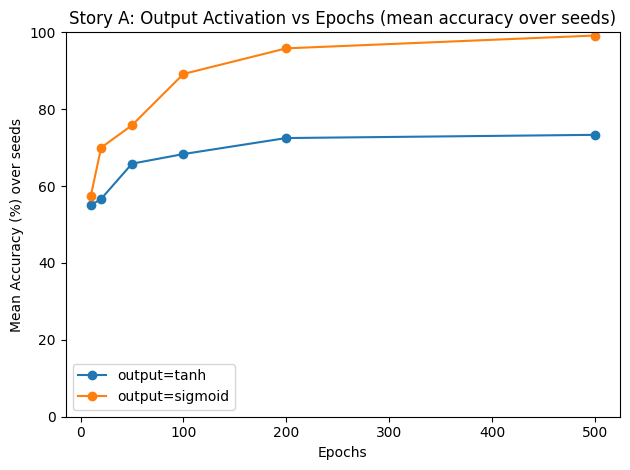

In [44]:
import torch
import matplotlib.pyplot as plt

# -----------------------------
# 1) Core: build/train/eval
# -----------------------------
def build_net(hidden_size: int, hidden_act_name: str, output_act_name: str) -> Network:
    """
    Build a network with single hidden layer (legacy function, use build_network instead).
    
    This function is kept for backward compatibility but internally uses
    the unified build_network function to avoid code duplication.
    
    Args:
        hidden_size: Size of the hidden layer.
        hidden_act_name: Activation for hidden layer ('tanh' or 'sigmoid').
        output_act_name: Activation for output layer ('tanh' or 'sigmoid').
    
    Returns:
        Configured Network object.
    
    Raises:
        ValueError: If activation names are invalid.
    """
    return build_network(
        input_size=2,
        hidden_layers=[hidden_size],
        output_size=1,
        hidden_activation=hidden_act_name,
        output_activation=output_act_name
    )

def predict_and_accuracy(
    net: Network,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    output_act_name: str
) -> float:
    """
    Predict and calculate accuracy for a trained network.
    
    Args:
        net: Trained Network object.
        x_train: Training input tensor.
        y_train: Training target tensor.
        output_act_name: Output activation name ('tanh' or 'sigmoid') to determine threshold.
    
    Returns:
        Accuracy value between 0.0 and 1.0.
    """
    preds = net.predicts(x_train)  # list of tensors
    
    # Threshold depends on output activation
    # sigmoid: [0, 1] range, threshold = 0.5
    # tanh: [-1, 1] range, threshold = 0.0
    thr = 0.5 if output_act_name == "sigmoid" else 0.0
    
    return calculate_accuracy(preds, y_train, threshold=thr)

def run_one_setting(
    hidden_size: int,
    hidden_act: str,
    output_act: str,
    lr: float,
    epochs: int,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    seed: int,
    print_every: int = None
) -> float:
    """
    Run a single training experiment with specified settings.
    
    Args:
        hidden_size: Size of hidden layer.
        hidden_act: Hidden layer activation ('tanh' or 'sigmoid').
        output_act: Output layer activation ('tanh' or 'sigmoid').
        lr: Learning rate.
        epochs: Number of training epochs.
        x_train: Training input tensor.
        y_train: Training target tensor.
        seed: Random seed for reproducibility.
        print_every: Print progress every n epochs. If None, auto-calculated based on epochs.
    
    Returns:
        Accuracy value after training.
    """
    torch.manual_seed(seed)
    net = build_net(hidden_size, hidden_act, output_act)
    
    # Auto-calculate print_every if not provided
    if print_every is None:
        if epochs <= 100:
            pe = 20
        elif epochs <= 200:
            pe = 50
        elif epochs <= 1000:
            pe = 100
        else:
            pe = 200
    else:
        pe = print_every
    
    net.fit(x_train, y_train, epochs=epochs, alpha=lr, print_every=pe)
    acc = predict_and_accuracy(net, x_train, y_train, output_act)
    return acc

def mean_min_max(vals) -> tuple:
    """
    Calculate mean, minimum, and maximum of a collection of values.
    
    Args:
        vals: Collection of numeric values.
    
    Returns:
        Tuple of (mean, minimum, maximum).
    """
    vals = list(vals)
    m = sum(vals) / len(vals)
    mn = min(vals)
    mx = max(vals)
    return m, mn, mx


# -----------------------------
# 2) Story A: output activation vs epochs
# -----------------------------
def sweep_epochs_compare_output_act(
    epochs_list: list[int],
    output_acts: tuple = ("tanh", "sigmoid"),
    hidden_size: int = 5,
    hidden_act: str = "tanh",
    lr: float = 0.1,
    seeds: range = range(0, 20),
    x_train: torch.Tensor = None,
    y_train: torch.Tensor = None
) -> dict:
    """
    Sweep over epochs and compare different output activation functions.
    
    Runs multiple experiments with different epochs and output activations,
    averaging results over multiple random seeds for statistical robustness.
    
    Args:
        epochs_list: List of epoch values to test.
        output_acts: Tuple of output activation names to compare (default: ('tanh', 'sigmoid')).
        hidden_size: Size of hidden layer (default: 5).
        hidden_act: Hidden layer activation (default: 'tanh').
        lr: Learning rate (default: 0.1).
        seeds: Range of random seeds for multiple runs (default: range(0, 20)).
        x_train: Training input tensor.
        y_train: Training target tensor.
    
    Returns:
        Dictionary with structure:
        results[output_act] = {
            "epochs": [...],
            "mean": [...],
            "min": [...],
            "max": [...]
        }
    """
    out = {}
    for out_act in output_acts:
        means, mins, maxs = [], [], []
        for ep in epochs_list:
            accs = [
                run_one_setting(hidden_size, hidden_act, out_act, lr, ep, x_train, y_train, seed)
                for seed in seeds
            ]
            m, mn, mx = mean_min_max(accs)
            means.append(m)
            mins.append(mn)
            maxs.append(mx)
        out[out_act] = {"epochs": list(epochs_list), "mean": means, "min": mins, "max": maxs}
    return out

def plot_storyA_epochs(
    results_dict: dict,
    title: str = "Story A: Output Activation vs Epochs (mean accuracy over seeds)"
) -> None:
    """
    Plot comparison of output activations across different epochs.
    
    Args:
        results_dict: Dictionary returned by sweep_epochs_compare_output_act.
        title: Plot title (default: "Story A: Output Activation vs Epochs...").
    """
    plt.figure()
    for out_act, d in results_dict.items():
        xs = d["epochs"]
        ys = [v * 100 for v in d["mean"]]
        plt.plot(xs, ys, marker="o", label=f"output={out_act}")

    plt.xlabel("Epochs")
    plt.ylabel("Mean Accuracy (%) over seeds")
    plt.ylim(0, 100)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# 3) Story B: output activation vs learning rate
# -----------------------------
def sweep_lr_compare_output_act(
    lr_list: list[float],
    output_acts: tuple = ("tanh", "sigmoid"),
    hidden_size: int = 5,
    hidden_act: str = "tanh",
    epochs: int = 200,
    seeds: range = range(0, 20),
    x_train: torch.Tensor = None,
    y_train: torch.Tensor = None
) -> dict:
    """
    Sweep over learning rates and compare different output activation functions.
    
    Runs multiple experiments with different learning rates and output activations,
    averaging results over multiple random seeds for statistical robustness.
    
    Args:
        lr_list: List of learning rate values to test.
        output_acts: Tuple of output activation names to compare (default: ('tanh', 'sigmoid')).
        hidden_size: Size of hidden layer (default: 5).
        hidden_act: Hidden layer activation (default: 'tanh').
        epochs: Number of training epochs (default: 200).
        seeds: Range of random seeds for multiple runs (default: range(0, 20)).
        x_train: Training input tensor.
        y_train: Training target tensor.
    
    Returns:
        Dictionary with structure:
        results[output_act] = {
            "lr": [...],
            "mean": [...],
            "min": [...],
            "max": [...]
        }
    """
    out = {}
    for out_act in output_acts:
        means, mins, maxs = [], [], []
        for lr in lr_list:
            accs = [
                run_one_setting(hidden_size, hidden_act, out_act, lr, epochs, x_train, y_train, seed)
                for seed in seeds
            ]
            m, mn, mx = mean_min_max(accs)
            means.append(m)
            mins.append(mn)
            maxs.append(mx)
        out[out_act] = {"lr": list(lr_list), "mean": means, "min": mins, "max": maxs}
    return out

def plot_storyB_lr(
    results_dict: dict,
    title: str = "Story B: Output Activation vs Learning Rate (mean accuracy over seeds)"
) -> None:
    """
    Plot comparison of output activations across different learning rates.
    
    Args:
        results_dict: Dictionary returned by sweep_lr_compare_output_act.
        title: Plot title (default: "Story B: Output Activation vs Learning Rate...").
    """
    plt.figure()
    for out_act, d in results_dict.items():
        xs = d["lr"]
        ys = [v * 100 for v in d["mean"]]
        plt.plot(xs, ys, marker="o", label=f"output={out_act}")

    plt.xlabel("Learning rate (lr)")
    plt.ylabel("Mean Accuracy (%) over seeds")
    plt.ylim(0, 100)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# 4) Run (example)
# -----------------------------
# Choose sweeps that actually show correlation
epochs_list = [10, 20, 50, 100, 200, 500]
lr_list = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

# Story A: epochs sweep
resA = sweep_epochs_compare_output_act(
    epochs_list=epochs_list,
    output_acts=("tanh", "sigmoid"),
    hidden_size=5,
    hidden_act="tanh",
    lr=0.1,
    seeds=range(0, 30),   # more seeds => smoother
    x_train=x_train,
    y_train=y_train
)
plot_storyA_epochs(resA)



On epoch 20 an average error = tensor(0.2826)
On epoch 40 an average error = tensor(0.2244)
On epoch 60 an average error = tensor(0.2191)
On epoch 80 an average error = tensor(0.2153)
On epoch 100 an average error = tensor(0.2121)
On epoch 20 an average error = tensor(0.2507)
On epoch 40 an average error = tensor(0.2353)
On epoch 60 an average error = tensor(0.2256)
On epoch 80 an average error = tensor(0.2191)
On epoch 100 an average error = tensor(0.2143)
On epoch 20 an average error = tensor(0.7559)
On epoch 40 an average error = tensor(0.3242)
On epoch 60 an average error = tensor(0.2802)
On epoch 80 an average error = tensor(0.2515)
On epoch 100 an average error = tensor(0.2332)
On epoch 20 an average error = tensor(0.3567)
On epoch 40 an average error = tensor(0.2902)
On epoch 60 an average error = tensor(0.2696)
On epoch 80 an average error = tensor(0.2581)
On epoch 100 an average error = tensor(0.2507)
On epoch 20 an average error = tensor(0.3231)
On epoch 40 an average error =

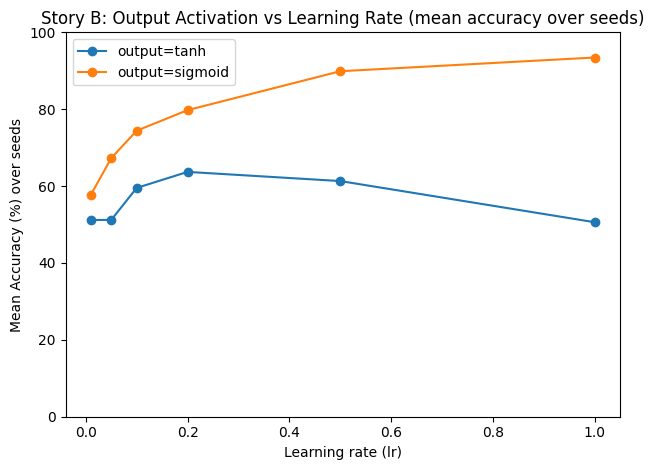

In [45]:

# Story B: lr sweep
resB = sweep_lr_compare_output_act(
    lr_list=lr_list,
    output_acts=("tanh", "sigmoid"),
    hidden_size=3,
    hidden_act="tanh",
    epochs=100,
    seeds=range(0, 42),
    x_train=x_train,
    y_train=y_train
)
plot_storyB_lr(resB)

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def _x_to_pair(x) -> tuple:
    """
    Extract (x1, x2) pair from input tensor.
    
    Args:
        x: Input tensor.
    
    Returns:
        Tuple of (x1, x2) as floats.
    """
    x = torch.as_tensor(x).float().view(-1)
    return float(x[0].item()), float(x[1].item())

def _y_to_int(y) -> int:
    """
    Extract label (0 or 1) from target tensor.
    
    Args:
        y: Target tensor.
    
    Returns:
        Integer label (0 or 1).
    """
    y = torch.as_tensor(y).float().view(-1)
    return int(y[0].item())

def plot_decision_boundary(
    net: Network,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    output_activation: str = "sigmoid",
    title: str = "XOR Decision Boundary"
) -> None:
    """
    Plot decision boundary for a trained network on XOR problem.
    
    Creates a high-resolution grid and visualizes the network's decision
    boundary with different colors for each class region.
    
    Args:
        net: Trained Network object.
        x_train: Training input tensor.
        y_train: Training target tensor.
        output_activation: Output activation name to determine threshold (default: 'sigmoid').
        title: Plot title (default: 'XOR Decision Boundary').
    """
    # Ngưỡng phân loại
    thr = 0.5 if output_activation == "sigmoid" else 0.0

    # 1) Create a higher resolution grid for smoother curves
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    h = 0.01 # Reduce h for finer grid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 2) Predict on grid
    Z = []
    # Convert to tensor once for speed if network is large (optional optimization)
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    # Predict each point (following old logic for compatibility)
    for i in range(len(grid)):
        p_tensor = grid_tensor[i].view(1, 2)
        pred = net.predicts([p_tensor])[0].item()
        Z.append(pred)
        
    Z = np.array(Z).reshape(xx.shape)

    # 3) Vẽ vùng quyết định (Thay đổi quan trọng)
    plt.figure(figsize=(7, 6))
    
    # Create colormap with only 2 colors for clear background division
    # Color 1: for class 0 (e.g., light Cyan), Color 2: for class 1 (e.g., light Magenta)
    cmap_background = ListedColormap(['#A0E7E5', '#FFB6C1']) 
    
    # Classify Z based on threshold to create 0 and 1
    Z_bin = (Z > thr).astype(int)
    
    # Draw colored background using pcolormesh or contourf with 2 levels
    plt.contourf(xx, yy, Z_bin, levels=[-0.5, 0.5, 1.5], cmap=cmap_background)
    
    # Vẽ thêm đường biên giới rõ nét màu đen
    plt.contour(xx, yy, Z, levels=[thr], colors='k', linestyles='-', linewidths=1.5)


    # 4) Draw data points (Keep original logic and consistent symbols)
    # Class 0: Circle 'o', darker color than background 0
    # Class 1: Cross 'x', darker color than background 1
    already_labeled_0 = False
    already_labeled_1 = False
    
    for i in range(len(x_train)):
        x1, x2 = _x_to_pair(x_train[i])
        y = _y_to_int(y_train[i])

        if y == 0:
            lbl = "Class 0" if not already_labeled_0 else None
            plt.scatter(x1, x2, marker='o', color='teal', s=80, edgecolors='k', label=lbl)
            already_labeled_0 = True
        else:
            lbl = "Class 1" if not already_labeled_1 else None
            plt.scatter(x1, x2, marker='x', color='crimson', s=80, linewidth=2, label=lbl)
            already_labeled_1 = True

    plt.xticks([0, 1])
    plt.yticks([0, 1])
    
    plt.title(title)
    plt.legend(loc='upper right') # Đặt chú thích ở góc dễ nhìn
    plt.tight_layout()
    plt.show()

On epoch 30 an average error = tensor(0.2777)
On epoch 60 an average error = tensor(0.2622)
On epoch 90 an average error = tensor(0.2501)
On epoch 120 an average error = tensor(0.2358)
On epoch 150 an average error = tensor(0.2165)
On epoch 180 an average error = tensor(0.1595)
On epoch 210 an average error = tensor(0.0708)
On epoch 240 an average error = tensor(0.0419)
On epoch 270 an average error = tensor(0.0286)
On epoch 300 an average error = tensor(0.0213)


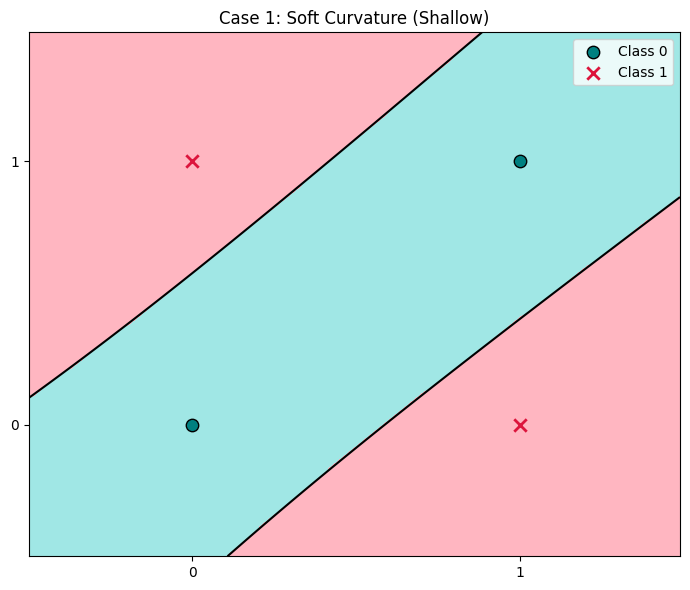

On epoch 50 an average error = tensor(0.0073)
On epoch 100 an average error = tensor(0.0018)
On epoch 150 an average error = tensor(0.0034)
On epoch 200 an average error = tensor(0.0020)
On epoch 250 an average error = tensor(0.0013)
On epoch 300 an average error = tensor(0.0012)
On epoch 350 an average error = tensor(0.0014)
On epoch 400 an average error = tensor(0.0011)
On epoch 450 an average error = tensor(0.0004)
On epoch 500 an average error = tensor(0.0006)
On epoch 100 an average error = tensor(0.1934)
On epoch 200 an average error = tensor(0.1776)
On epoch 300 an average error = tensor(0.1748)
On epoch 400 an average error = tensor(0.1736)
On epoch 500 an average error = tensor(0.1726)
On epoch 600 an average error = tensor(0.1641)
On epoch 700 an average error = tensor(0.0083)
On epoch 800 an average error = tensor(0.0029)
On epoch 900 an average error = tensor(0.0017)
On epoch 1000 an average error = tensor(0.0011)


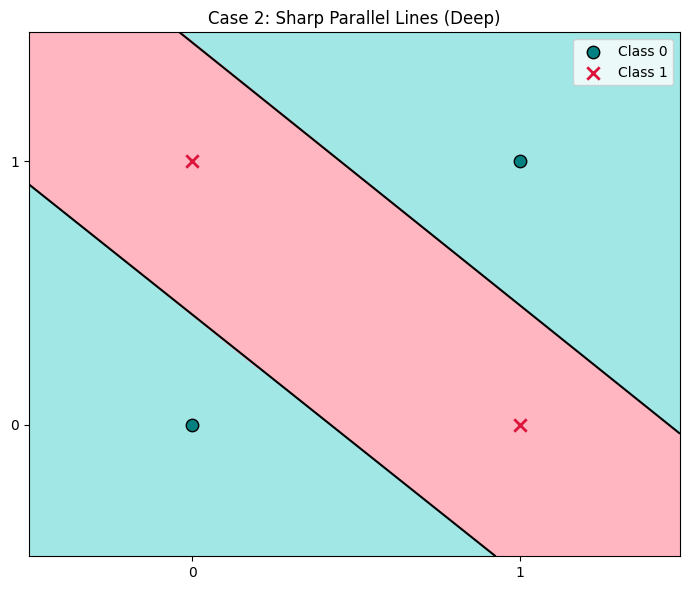

On epoch 500 an average error = tensor(0.0413)
On epoch 1000 an average error = tensor(0.0102)
On epoch 1500 an average error = tensor(0.0053)
On epoch 2000 an average error = tensor(0.0035)


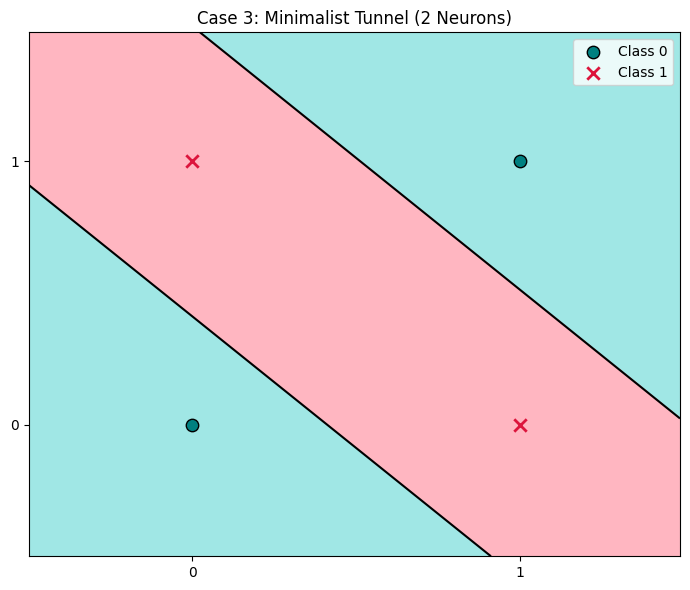

On epoch 100 an average error = tensor(0.2162)
On epoch 200 an average error = tensor(0.2080)
On epoch 300 an average error = tensor(0.2071)
On epoch 400 an average error = tensor(0.0316)
On epoch 500 an average error = tensor(0.0017)


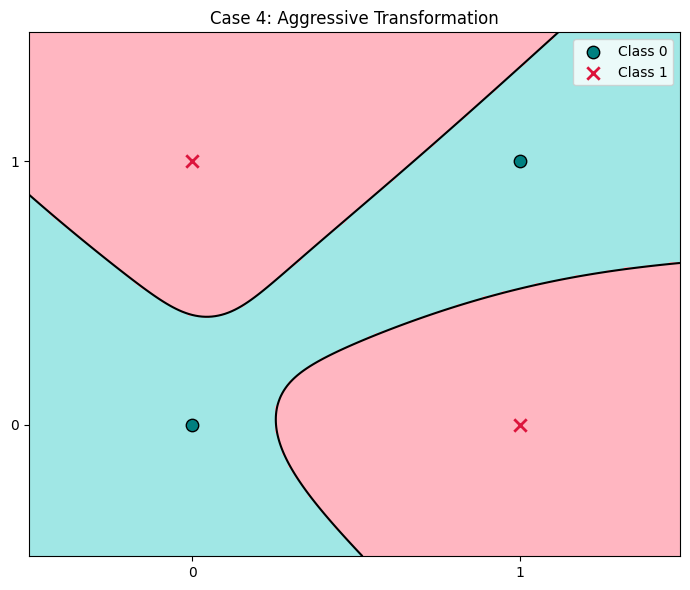

In [47]:
def build_net_with_depth(
    hidden_layers: list[int],
    hidden_activation: str = "tanh",
    output_activation: str = "sigmoid"
) -> Network:
    """
    Build a network with multiple hidden layers (legacy function, use build_network instead).
    
    This function is kept for backward compatibility but internally uses
    the unified build_network function to avoid code duplication.
    
    Args:
        hidden_layers: List of hidden layer sizes, e.g. [3] or [3, 3] or [2, 4, 8].
        hidden_activation: Activation function for all hidden layers (default: 'tanh').
        output_activation: Activation function for output layer (default: 'sigmoid').
    
    Returns:
        Configured Network object.
    
    Raises:
        ValueError: If activation names are invalid.
    
    Example:
        >>> net = build_net_with_depth([3])
        >>> # Creates: Input(2) -> Hidden(3) -> Output(1)
        
        >>> net = build_net_with_depth([2, 4, 8])
        >>> # Creates: Input(2) -> Hidden(2) -> Hidden(4) -> Hidden(8) -> Output(1)
    """
    return build_network(
        input_size=2,
        hidden_layers=hidden_layers,
        output_size=1,
        hidden_activation=hidden_activation,
        output_activation=output_activation
    )


# Test Case 1
torch.manual_seed(10) # Seed for reproducibility
net1 = build_net_with_depth(hidden_layers=[3], hidden_activation="tanh")
net1.fit(x_train, y_train, epochs=300, alpha=0.1, print_every=30)
plot_decision_boundary(net1, x_train, y_train, title="Case 1: Soft Curvature (Shallow)")
net.fit(x_train, y_train, epochs=500, alpha=0.2, print_every=50)

# Test Case 2
torch.manual_seed(42)
net2 = build_net_with_depth(hidden_layers=[2, 3, 3], hidden_activation="tanh")
net2.fit(x_train, y_train, epochs=1000, alpha=0.1, print_every=100)
plot_decision_boundary(net2, x_train, y_train, title="Case 2: Sharp Parallel Lines (Deep)")

# Test Case 3
torch.manual_seed(1)
net3 = build_net_with_depth(hidden_layers=[2], hidden_activation="tanh")
net3.fit(x_train, y_train, epochs=2000, alpha=0.05, print_every=500)
plot_decision_boundary(net3, x_train, y_train, title="Case 3: Minimalist Tunnel (2 Neurons)")

# Test Case 4
torch.manual_seed(99)
net4 = build_net_with_depth(hidden_layers=[4, 4], hidden_activation="tanh")
net4.fit(x_train, y_train, epochs=500, alpha=0.8, print_every=100)
plot_decision_boundary(net4, x_train, y_train, title="Case 4: Aggressive Transformation")

On epoch 10 an average error = tensor(0.1940)
On epoch 20 an average error = tensor(0.0756)
On epoch 30 an average error = tensor(0.0438)
On epoch 40 an average error = tensor(0.0306)
On epoch 50 an average error = tensor(0.0234)
On epoch 60 an average error = tensor(0.0187)
On epoch 70 an average error = tensor(0.0155)
On epoch 80 an average error = tensor(0.0131)
On epoch 90 an average error = tensor(0.0113)
On epoch 100 an average error = tensor(0.0098)


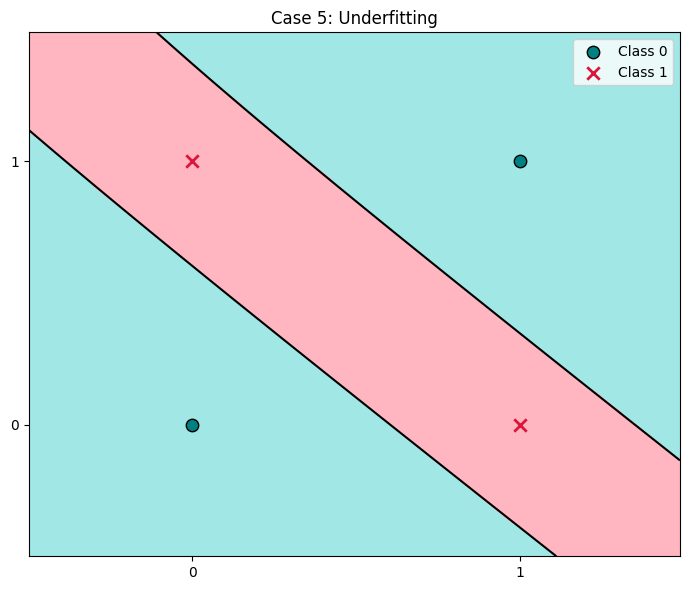

In [48]:

# Test Case 5
net5 = build_net_with_depth(hidden_layers=[2, 4, 8], hidden_activation="tanh")
net5.fit(x_train, y_train, epochs=100, alpha=0.1, print_every=10)
plot_decision_boundary(net5, x_train, y_train, title="Case 5: Underfitting")

## 9. Save and Load Model


In [52]:
# Train a sample model to test save/load
print("="*80)
print("Train model")
print("="*80)

torch.manual_seed(42)
net_train = build_network(
    input_size=2,
    hidden_layers=[3],
    output_size=1,
    hidden_activation='tanh',
    output_activation='sigmoid'
)

# Train model
net_train.fit(x_train, y_train, epochs=200, alpha=0.2, print_every=100)

# Test predictions before saving
print("\n" + "="*80)
print("Predictions before saving:")
print("="*80)
predictions_before = net_train.predicts(x_train)
for i, pred in enumerate(predictions_before):
    print(f"Input: {x_train[i].tolist()[0]} -> Prediction: {pred.item():.4f} (True: {y_train[i].item():.2f})")

# Calculate accuracy
accuracy_before = calculate_accuracy(predictions_before, y_train, threshold=0.5)
print(f"\nAccuracy before saving: {accuracy_before*100:.1f}%")

# Save model
model_path = "xor_model.pkl"
net_train.save(model_path)


Train model
On epoch 100 an average error = tensor(0.1861)
On epoch 200 an average error = tensor(0.0209)

Predictions before saving:
Input: [0.0, 0.0] -> Prediction: 0.1428 (True: 0.00)
Input: [0.0, 1.0] -> Prediction: 0.8378 (True: 1.00)
Input: [1.0, 0.0] -> Prediction: 0.8597 (True: 1.00)
Input: [1.0, 1.0] -> Prediction: 0.1166 (True: 0.00)

Accuracy before saving: 100.0%
Model saved to xor_model.pkl


In [53]:
# Load weights và tự động khôi phục cấu trúc mạng
print("\n" + "="*80)
# Không cần khởi tạo net_loaded trước, hàm load sẽ trả về một đối tượng Network mới
net_loaded = Network.load(model_path) 

# Test predictions sau khi load
print("\n" + "="*80)
print("Predictions after loading:")
print("="*80)

# Dữ liệu x_train cần được chuẩn hóa (normalize) giống lúc train [cite: 172-175]
predictions_after = net_loaded.predicts(x_train)

for i, pred in enumerate(predictions_after):
    # Lấy giá trị dự đoán và nhãn thực tế để in ra
    # Giả sử đầu ra là sigmoid nên dùng .item() để lấy số thực
    print(f"Input: {x_train[i].tolist()[0]} -> Prediction: {pred.item():.4f} (True: {y_train[i].item():.2f})")

# Tính toán độ chính xác
accuracy_after = calculate_accuracy(predictions_after, y_train, threshold=0.5)
print(f"\nAccuracy after loading: {accuracy_after*100:.1f}%")


Model loaded from xor_model.pkl

Predictions after loading:
Input: [0.0, 0.0] -> Prediction: -0.9460 (True: 0.00)
Input: [0.0, 1.0] -> Prediction: 0.9278 (True: 1.00)
Input: [1.0, 0.0] -> Prediction: 0.9481 (True: 1.00)
Input: [1.0, 1.0] -> Prediction: -0.9658 (True: 0.00)

Accuracy after loading: 100.0%
